In [2]:
import os
import datetime
import regex
import pandas as pd
import numpy as np
import emoji
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [15]:
# open file chat.txt
file_path = "chat.txt"
# read one line at time
with open(file_path, mode='r', encoding="utf8") as f:
    data = f.readlines()

In [16]:
dataset = data [1:]
cleaned_data = []
datamess = []

for line in dataset:
    # Check, whether it is a new line or not
    # If the following characters are in the line -> assumption it is NOT a new line
    if '/' in line and ':' in line and ',' in line and '[' in line:
        # grab the info and cut it out
        date = line.split("[")[1].split(",")[0]
        line2 = line[len(date):]
        time = line2.split(",")[1].split("]")[0]
        line3 = line2[len(time):]
        sender = line3.split("]")[1].split(":")[0]
        line4 = line3[len(sender):]
        message = line4[5:-1]
        message = message.replace(" \u200e", "" ).replace("\n", "")
        cleaned_data.append([date, time[1:], sender[1:], message])
        
    # else, assumption -> new line. Append new line to previous 'message'
    else:
        new = cleaned_data[-1][-1] + " " + line
        cleaned_data[-1][-1] = new

In [18]:
df = pd.DataFrame(cleaned_data, columns=["Date", 'Time', 'Author', 'Message'])
df['Date'] = pd.to_datetime(df['Date'])
print(df.tail(20))
print(df.info())
print(df.Author.unique())

            Date      Time  Author  \
15035 2023-01-13  20:16:03    Otti   
15036 2023-01-13  20:16:41  Paloni   
15037 2023-01-15  13:24:36  Paloni   
15038 2023-01-15  13:24:40  Paloni   
15039 2023-01-15  13:28:48  Paloni   
15040 2023-01-15  13:28:59    Otti   
15041 2023-01-15  13:29:08    Otti   
15042 2023-01-15  13:29:27    Otti   
15043 2023-01-15  13:30:30  Paloni   
15044 2023-01-15  13:31:17    Otti   
15045 2023-01-15  13:33:33  Paloni   
15046 2023-01-15  13:34:04  Paloni   
15047 2023-01-15  13:34:41  Paloni   
15048 2023-01-15  13:42:40    Otti   
15049 2023-01-15  13:43:19    Otti   
15050 2023-01-15  13:58:54  Paloni   
15051 2023-01-15  13:59:40  Paloni   
15052 2023-01-15  14:01:45  Paloni   
15053 2023-01-15  14:07:53    Otti   
15054 2023-01-17  18:17:33    Otti   

                                                 Message  
15035  Io non bevo mai se poi devo guidare ma grazie ...  
15036  <allegato: 00015040-AUDIO-2023-01-13-20-16-41....  
15037                   

In [19]:
total_messages = df.shape[0]
print(total_messages)

15055


In [20]:
media_messages = df[df["Message"].str.contains('<allegato: ')].shape[0]
print(media_messages)

3187


In [21]:
def split_count(text):
    emoji_list = []
    data = regex.findall(r'\X',text)
    for word in data:
        if any(char in emoji.EMOJI_DATA for char in word):
            emoji_list.append(word)
    return emoji_list
df['emoji'] = df["Message"].apply(split_count)

emojis = sum(df['emoji'].str.len())
print(emojis)

5438


In [22]:
URLPATTERN = r'(https?://\S+)'
df['urlcount'] = df.Message.apply(lambda x: regex.findall(URLPATTERN, x)).str.len()
links = np.sum(df.urlcount)

print("Chats between Otti and Paloni")
print("Total Messages: ", total_messages)
print("Number of Media Shared: ", media_messages)
print("Number of Emojis Shared", emojis)
print("Number of Links Shared", links)

Chats between Otti and Paloni
Total Messages:  15055
Number of Media Shared:  3187
Number of Emojis Shared 5438
Number of Links Shared 71


In [23]:
media_messages_df = df[df["Message"].str.contains('<allegato: ')]
messages_df = df.drop(media_messages_df.index)
messages_df['Letter_Count'] = messages_df['Message'].apply(lambda s : len(s))
messages_df['Word_Count'] = messages_df['Message'].apply(lambda s : len(s.split(' ')))
messages_df["MessageCount"]=1

l = ["Paloni", "Otti"]
for i in range(len(l)):
  # Filtering out messages of particular user
  req_df= messages_df[messages_df["Author"] == l[i]]
  # req_df will contain messages of only one particular user
  print(f'Stats of {l[i]} -')
  # shape will print number of rows which indirectly means the number of messages
  print('Messages Sent', req_df.shape[0])
  #Word_Count contains of total words in one message. Sum of all words/ Total Messages will yield words per message
  words_per_message = (np.sum(req_df['Word_Count']))/req_df.shape[0]
  print('Average Words per message', words_per_message)
  #media conists of media messages
  media = media_messages_df[media_messages_df['Author'] == l[i]].shape[0]
  print('Media Messages Sent', media)
  # emojis conists of total emojis
  emojis = sum(req_df['emoji'].str.len())
  print('Emojis Sent', emojis)
  #links consist of total links
  links = sum(req_df["urlcount"])   
  print('Links Sent', links)

Stats of Paloni -
Messages Sent 5783
Average Words per message 6.526716237247103
Media Messages Sent 2000
Emojis Sent 1908
Links Sent 43
Stats of Otti -
Messages Sent 6085
Average Words per message 7.563516844700082
Media Messages Sent 1187
Emojis Sent 3530
Links Sent 28


In [24]:
total_emojis_list = list(set([a for b in messages_df.emoji for a in b]))
total_emojis = len(total_emojis_list)

total_emojis_list = list([a for b in messages_df.emoji for a in b])
emoji_dict = dict(Counter(total_emojis_list))
emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
for i in emoji_dict:
  print(i)
  
emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
import plotly.express as px
fig = px.pie(emoji_df, values='count', names='emoji')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

('🤣', 1029)
('😂', 792)
('😅', 295)
('😘', 292)
('💪🏻', 261)
('❤️', 224)
('🥳', 219)
('🤩', 204)
('❤', 177)
('👏🏻', 171)
('😍', 146)
('😊', 102)
('🤦🏼\u200d♀️', 92)
('🤗', 85)
('☺️', 82)
('🤪', 66)
('🥺', 59)
('😜', 51)
('😝', 48)
('🙌🏻', 42)
('🎉', 34)
('🙈', 34)
('😱', 34)
('🤦🏻\u200d♂️', 34)
('😓', 31)
('🙅🏼\u200d♀️', 26)
('🥰', 25)
('🤓', 25)
('😫', 24)
('🤙🏻', 23)
('☀️', 22)
('🤔', 22)
('💫', 22)
('😖', 21)
('😭', 20)
('😒', 20)
('🤦🏻\u200d♂', 20)
('🌟', 19)
('😉', 18)
('😎', 16)
('🤨', 16)
('😑', 15)
('😞', 15)
('😁', 15)
('🙆🏼\u200d♀️', 15)
('😔', 12)
('😆', 12)
('👍🏻', 11)
('🤞🏻', 11)
('😻', 11)
('🦌', 11)
('⭐️', 10)
('😡', 10)
('😬', 10)
('😩', 9)
('🤬', 9)
('👊🏼', 9)
('🌹', 8)
('👋🏻', 8)
('🖤', 8)
('💓', 8)
('😢', 8)
('💝', 8)
('😣', 7)
('🔝', 7)
('💸', 7)
('🙃', 6)
('🌈', 6)
('🤭', 5)
('🙄', 5)
('😌', 5)
('😹', 5)
('✨', 5)
('😤', 5)
('🎄', 5)
('😐', 5)
('😛', 5)
('🤷🏻\u200d♂️', 5)
('🤷🏼\u200d♀️', 4)
('👌🏼', 4)
('☹️', 4)
('👀', 4)
('🐺', 4)
('🤤', 4)
('😰', 4)
('👩\u200d💻', 4)
('🎾', 4)
('🎊', 4)
('🤮', 4)
('😧', 4)
('😵', 4)
('😳', 3)
('👥', 3)
('🥴', 3)
('😶'

There are 462061 words in all the messages.


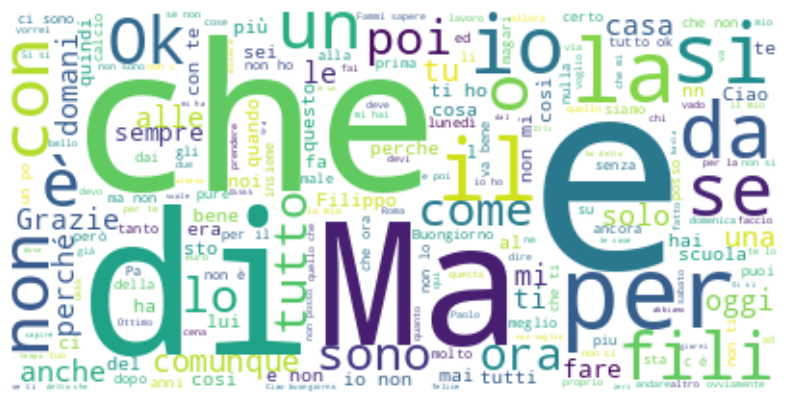

In [25]:
text = " ".join(review for review in messages_df.Message)
print ("There are {} words in all the messages.".format(len(text)))
stopwords = set(STOPWORDS)
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
# Display the generated image:
# the matplotlib way:
plt.figure( figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Author name Paloni


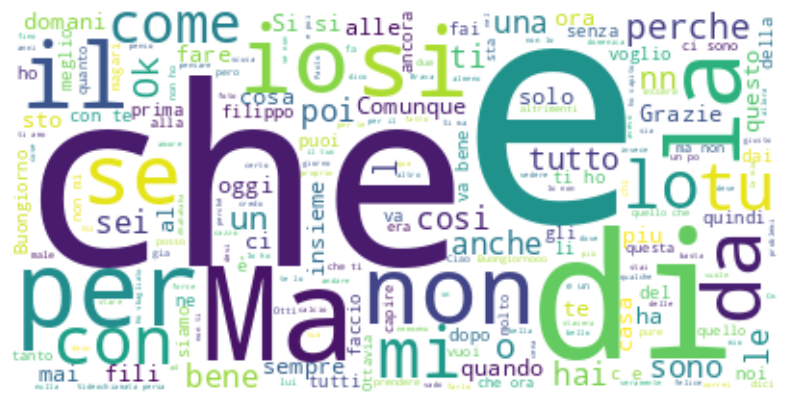

Author name Otti


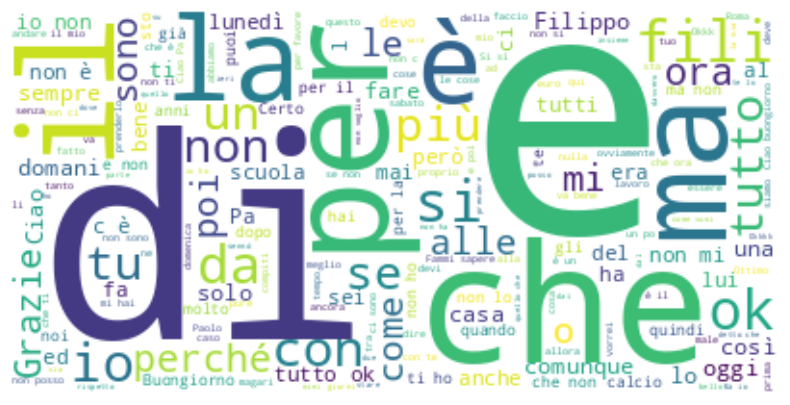

In [26]:
l = ["Paloni", "Otti"]
for i in range(len(l)):
  dummy_df = messages_df[messages_df['Author'] == l[i]]
  text = " ".join(review for review in dummy_df.Message)
  stopwords = set(STOPWORDS)
  #Generate a word cloud image
  print('Author name',l[i])
  wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
  #Display the generated image   
  plt.figure( figsize=(10,5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()